<a href="https://colab.research.google.com/github/adem0204/Projet-de-Classification-d-Images-/blob/main/Projet_ml_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELLULE 1 : Connexion au Drive ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports, Chargement et Extraction HOG

In [ ]:
import os
import cv2
from tqdm import tqdm
import shutil

# --- CONFIGURATION ---
# Le dossier que tu as téléchargé (YOLO)
SOURCE_YOLO = "/content/drive/MyDrive/Child-Adult-Elderly.v2i.yolov5pytorch"

# Le dossier PROPRE qu'on va créer (C'est celui-là qu'on utilisera après)
OUTPUT_DIR = "/content/drive/MyDrive/Dataset_Final_Cropped"

# Les classes (ordre standard Roboflow)
CLASSES_NAMES = ['child', 'adult', 'elderly']

def create_cropped_dataset(source_dir, output_dir):
    print(f"🚀 Démarrage de la conversion YOLO -> Dossiers Classification...")

    splits = ['train', 'valid', 'test']

    for split in splits:
        # YOLO range souvent dans 'train/images' ou juste 'train' selon la version
        # On teste les deux chemins possibles
        images_dir_1 = os.path.join(source_dir, split, 'images')
        labels_dir_1 = os.path.join(source_dir, split, 'labels')

        images_dir_2 = os.path.join(source_dir, split) # Parfois les images sont direct là

        if os.path.exists(images_dir_1):
            images_dir, labels_dir = images_dir_1, labels_dir_1
        else:
            images_dir, labels_dir = images_dir_2, images_dir_2 # Fallback

        if not os.path.exists(images_dir):
            print(f"⚠️ Split '{split}' ignoré (dossier introuvable).")
            continue

        print(f"📂 Traitement du dossier : {split} ...")

        # Créer les dossiers de destination (child, adult, elderly)
        for cls in CLASSES_NAMES:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

        # On cherche les fichiers labels (.txt)
        label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

        count_crops = 0
        for label_file in tqdm(label_files):
            try:
                # Trouver l'image correspondante
                base_name = os.path.splitext(label_file)[0]
                img_path = None
                for ext in ['.jpg', '.jpeg', '.png']:
                    temp_path = os.path.join(images_dir, base_name + ext)
                    if os.path.exists(temp_path):
                        img_path = temp_path
                        break

                if not img_path: continue

                # Lire l'image
                img = cv2.imread(img_path)
                if img is None: continue
                h, w, _ = img.shape

                # Lire le fichier txt (Labels)
                with open(os.path.join(labels_dir, label_file), 'r') as f:
                    lines = f.readlines()

                for i, line in enumerate(lines):
                    parts = line.strip().split()
                    class_id = int(parts[0])

                    if class_id >= len(CLASSES_NAMES): continue

                    # Coordonnées YOLO -> Pixels
                    x_c, y_c, bbox_w, bbox_h = map(float, parts[1:5])
                    x1 = int((x_c - bbox_w / 2) * w)
                    y1 = int((y_c - bbox_h / 2) * h)
                    x2 = int((x_c + bbox_w / 2) * w)
                    y2 = int((y_c + bbox_h / 2) * h)

                    # Crop (Découpage)
                    x1, y1 = max(0, x1), max(0, y1)
                    x2, y2 = min(w, x2), min(h, y2)
                    crop = img[y1:y2, x1:x2]

                    if crop.size == 0: continue

                    # Sauvegarde dans le bon dossier (child/adult/elderly)
                    class_name = CLASSES_NAMES[class_id]
                    save_name = f"{base_name}_{i}.jpg"
                    save_path = os.path.join(output_dir, split, class_name, save_name)
                    cv2.imwrite(save_path, crop)
                    count_crops += 1

            except Exception:
                pass
        print(f"   -> {count_crops} images extraites pour {split}")

    print(f"\n✅ Terminé ! Utilise maintenant ce chemin : {output_dir}")

# --- EXECUTION ---
create_cropped_dataset(SOURCE_YOLO, OUTPUT_DIR)

🚀 Démarrage de la conversion YOLO -> Dossiers Classification...
📂 Traitement du dossier : train ...


100%|██████████| 3276/3276 [34:58<00:00,  1.56it/s]


   -> 42570 images extraites pour train
📂 Traitement du dossier : valid ...


100%|██████████| 315/315 [02:48<00:00,  1.87it/s]


   -> 4853 images extraites pour valid
📂 Traitement du dossier : test ...


100%|██████████| 158/158 [01:36<00:00,  1.64it/s]

   -> 2517 images extraites pour test

✅ Terminé ! Utilise maintenant ce chemin : /content/drive/MyDrive/Dataset_Final_Cropped


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
IMG_SIZE = 128
EXPECTED_CATEGORIES = ["child", "adult", "elderly"]

# ⚠️ CHEMIN CORRIGÉ : On pointe vers le dossier créé par le script précédent
BASE_DIR = "/content/drive/MyDrive/Dataset_Final_Cropped"
DATA_DIR = os.path.join(BASE_DIR, "train")

def load_data_and_extract_features(data_dir):
    features = []
    labels = []

    print(f"📂 Recherche dans le dossier : {data_dir}")

    if not os.path.exists(data_dir):
        print("❌ ERREUR : Tu dois d'abord lancer le 'Magic Script' (Étape 1) !")
        return np.array([]), np.array([])

    available_folders = os.listdir(data_dir)
    print(f"   Dossiers trouvés : {available_folders}")

    for category in EXPECTED_CATEGORIES:
        if category not in available_folders:
            print(f"⚠️ Dossier '{category}' introuvable.")
            continue

        path = os.path.join(data_dir, category)
        class_num = EXPECTED_CATEGORIES.index(category)

        print(f"   Chargement '{category}'...")
        count = 0

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is None: continue

                # Resize & HOG
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)

                features.append(hog_features)
                labels.append(class_num)
                count += 1
            except: pass

        print(f"   ✅ {count} images.")

    return np.array(features), np.array(labels)

# Exécution
X, y = load_data_and_extract_features(DATA_DIR)

if len(X) > 0:
    print(f"\nsuccès ! Total images : {len(X)}")
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

📂 Recherche dans le dossier : /content/drive/MyDrive/Dataset_Final_Cropped/train
   Dossiers trouvés : ['child', 'adult', 'elderly']
   Chargement 'child'...
   ✅ 17418 images.
   Chargement 'adult'...
   ✅ 23217 images.
   Chargement 'elderly'...
   ✅ 1935 images.

succès ! Total images : 42570
Train: (29799, 8100), Val: (6385, 8100), Test: (6386, 8100)


🚀 Démarrage de l'entraînement des modèles...

--- 1. Optimisation KNN (Recherche du meilleur K) ---
⏳ Ce calcul peut prendre du temps (beaucoup de données)...
   k=1 -> Accuracy Val: 93.22% (136.2s)
   k=3 -> Accuracy Val: 80.69% (114.9s)
   k=5 -> Accuracy Val: 67.61% (112.2s)
   k=7 -> Accuracy Val: 61.64% (112.3s)
   k=9 -> Accuracy Val: 57.98% (110.6s)
✅ Meilleur K trouvé : 1 (Accuracy Val: 93.22%)

📊 Résultats KNN (k=1) sur le Test Set :
              precision    recall  f1-score   support

       child       0.87      0.97      0.92      2613
       adult       0.99      0.90      0.94      3483
     elderly       0.81      0.90      0.86       290

    accuracy                           0.93      6386
   macro avg       0.89      0.92      0.91      6386
weighted avg       0.93      0.93      0.93      6386



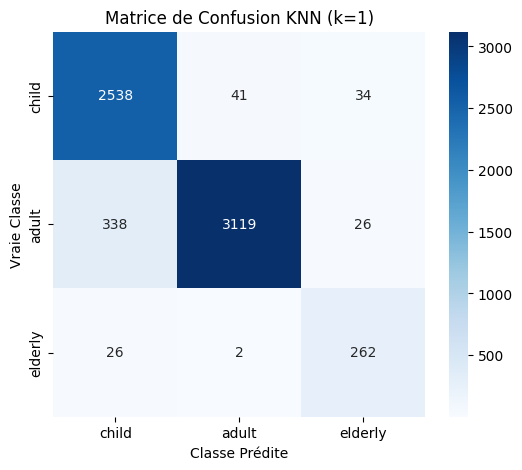


--- 2. Optimisation Arbre de Décision (Profondeur) ---
✅ Meilleure Profondeur : 7 (Accuracy Val: 72.23%)

📊 Résultats Decision Tree (Depth=7) sur le Test Set :
              precision    recall  f1-score   support

       child       0.72      0.57      0.64      2613
       adult       0.73      0.89      0.80      3483
     elderly       0.53      0.15      0.24       290

    accuracy                           0.72      6386
   macro avg       0.66      0.54      0.56      6386
weighted avg       0.72      0.72      0.71      6386



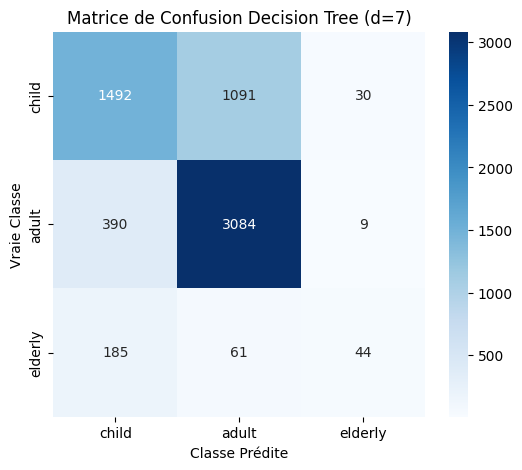


--- 3. Entraînement Naive Bayes ---
✅ Accuracy Naive Bayes : 56.04%

📊 Résultats Naive Bayes sur le Test Set :
              precision    recall  f1-score   support

       child       0.44      0.07      0.13      2613
       adult       0.72      0.90      0.80      3483
     elderly       0.15      0.81      0.25       290

    accuracy                           0.56      6386
   macro avg       0.44      0.60      0.39      6386
weighted avg       0.58      0.56      0.50      6386



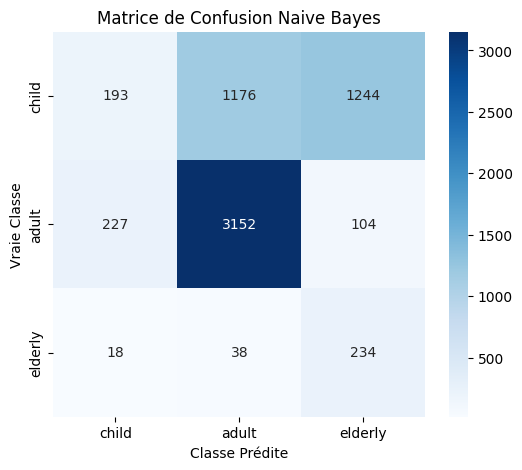


🎉 TERMINÉ ! Tu as tous les résultats pour ton rapport.


In [ ]:
# --- CELLULE 3 : Entraînement et Évaluation des Modèles ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Fonction pour afficher la matrice de confusion (Jolie pour le rapport)
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=EXPECTED_CATEGORIES, yticklabels=EXPECTED_CATEGORIES)
    plt.title(title)
    plt.ylabel('Vraie Classe')
    plt.xlabel('Classe Prédite')
    plt.show()

print("🚀 Démarrage de l'entraînement des modèles...\n")

# ==========================================
# 1. K-NEAREST NEIGHBORS (KNN)
# ==========================================
print(f"{'='*40}")
print("--- 1. Optimisation KNN (Recherche du meilleur K) ---")
print("⏳ Ce calcul peut prendre du temps (beaucoup de données)...")

k_values = [1, 3, 5, 7, 9] # On teste ces valeurs
best_k = 1
best_score = 0
best_knn = None

for k in k_values:
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = knn.score(X_val, y_val)
    elapsed = time.time() - start_time
    print(f"   k={k} -> Accuracy Val: {score:.2%} ({elapsed:.1f}s)")

    if score > best_score:
        best_score = score
        best_k = k
        best_knn = knn

print(f"✅ Meilleur K trouvé : {best_k} (Accuracy Val: {best_score:.2%})")

# Évaluation finale sur TEST
print(f"\n📊 Résultats KNN (k={best_k}) sur le Test Set :")
y_pred_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn, target_names=EXPECTED_CATEGORIES))
plot_confusion_matrix(y_test, y_pred_knn, f"Matrice de Confusion KNN (k={best_k})")


# ==========================================
# 2. ARBRE DE DÉCISION (Decision Tree)
# ==========================================
print(f"\n{'='*40}")
print("--- 2. Optimisation Arbre de Décision (Profondeur) ---")

depths = range(1, 16, 2) # Profondeur de 1 à 15
best_depth = 1
best_dt_score = 0
best_dt = None

for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    score = dt.score(X_val, y_val)
    # print(f"   Depth={d} -> Accuracy Val: {score:.2%}")

    if score > best_dt_score:
        best_dt_score = score
        best_depth = d
        best_dt = dt

print(f"✅ Meilleure Profondeur : {best_depth} (Accuracy Val: {best_dt_score:.2%})")

# Évaluation finale sur TEST
print(f"\n📊 Résultats Decision Tree (Depth={best_depth}) sur le Test Set :")
y_pred_dt = best_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names=EXPECTED_CATEGORIES))
plot_confusion_matrix(y_test, y_pred_dt, f"Matrice de Confusion Decision Tree (d={best_depth})")


# ==========================================
# 3. NAIVE BAYES (Gaussian)
# ==========================================
print(f"\n{'='*40}")
print("--- 3. Entraînement Naive Bayes ---")

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred_nb)

print(f"✅ Accuracy Naive Bayes : {nb_acc:.2%}")

# Évaluation finale sur TEST
print(f"\n📊 Résultats Naive Bayes sur le Test Set :")
print(classification_report(y_test, y_pred_nb, target_names=EXPECTED_CATEGORIES))
plot_confusion_matrix(y_test, y_pred_nb, "Matrice de Confusion Naive Bayes")

print("\n🎉 TERMINÉ ! Tu as tous les résultats pour ton rapport.")

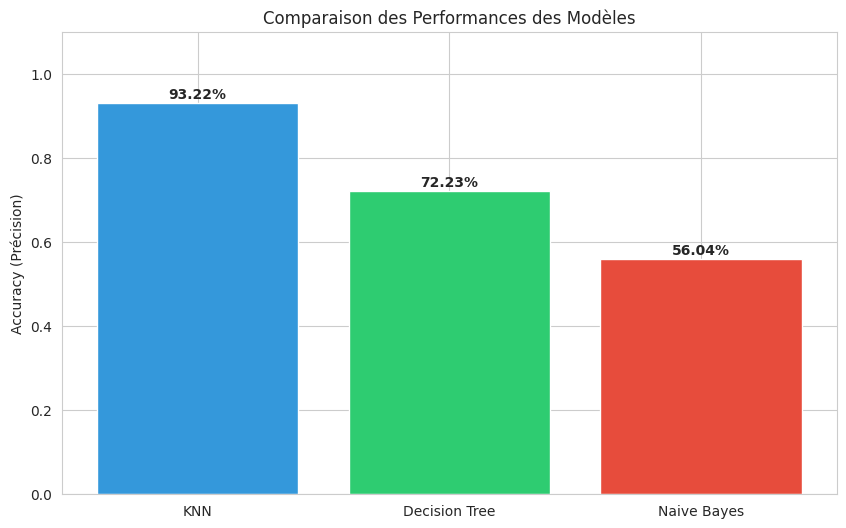


🏆 Le meilleur modèle est : KNN avec 93.22%


In [ ]:
# --- CELLULE 4 : Comparaison Finale des Modèles ---
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des scores (On suppose que les modèles sont déjà entraînés)
scores = {
    'KNN': best_score,            # Score du meilleur KNN
    'Decision Tree': best_dt_score, # Score du meilleur Arbre
    'Naive Bayes': nb_acc         # Score du Naive Bayes
}

# Création du Graphique
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
bars = plt.bar(scores.keys(), scores.values(), color=['#3498db', '#2ecc71', '#e74c3c'])

# Ajouter les pourcentages au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', fontweight='bold')

plt.ylim(0, 1.1) # Pour laisser de la place au-dessus
plt.ylabel('Accuracy (Précision)')
plt.title('Comparaison des Performances des Modèles')
plt.show()

# Afficher le gagnant
best_model_name = max(scores, key=scores.get)
print(f"\n🏆 Le meilleur modèle est : {best_model_name} avec {scores[best_model_name]:.2%}")